# GSE142445

**缺血性卒中第一个单细胞公开数据**

1. 标题: [大量单细胞 RNAseq 揭示大脑中动脉闭塞后脑细胞的动态变化](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE142445)
2. 种属: Mus musculus
3. 实验类型: Expression profiling by high throughput sequencing
4. 总结: 我们使用 10XGenomics 单细胞 3' 基于液滴的单细胞方法来分析大脑中动脉闭塞后的成年小鼠皮质脑细胞。
5. 整体设计: 从 MCAO 后的 2 个脑区 （同侧病灶周围区域及其相应的对侧区域） 和 4 个不同时间点 （4 小时、 1 天、 3 天和 7 天） 分离并分析单个脑细胞。此外，还分析了来自 3 只未受伤小鼠对应区域的单细胞。
6. 引用文献: [Wu DM, Liu JP, Liu J, Ge WH et al. Immune pathway activation in neurons triggers neural damage after stroke. Cell Rep 2023 Nov 28;42(11):113368. PMID: 37917581](https://pubmed.ncbi.nlm.nih.gov/37917581/)
7. 提交日期: Dec 20, 2019  12月 20， 2019 
8. 平台: GPL24247	Illumina NovaSeq 6000 (Mus musculus)

|ID|处理|
|--|---|
|GSM4227433|4hr_contralateral|
|GSM4227434|4hr_ipsilateral|
|GSM4227435|1d_contralateral|
|GSM4227436|1d_ipsilateral|
|GSM4227437|3d_contralateral|
|GSM4227438|3d_ipsilateral|
|GSM4227439|7d_contralateral|
|GSM4227440|7d_ipsilateral|
|GSM4227441|uninjured_1|
|GSM4227442|uninjured_2|
|GSM4227443|uninjured_3|


In [1]:
%reset -f
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import yaml
import os

print(os.getcwd())
sc.settings.verbosity = 3
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
targets = pd.DataFrame({
    "id": ["GSM4227433", "GSM4227434", "GSM4227435", "GSM4227436", "GSM4227437", "GSM4227438", 
           "GSM4227439", "GSM4227440", "GSM4227441", "GSM4227442", "GSM4227443"],
    "condition": ["4hr_contralateral", "4hr_ipsilateral", "1d_contralateral", "1d_ipsilateral", "3d_contralateral", 
                  "3d_ipsilateral", "7d_contralateral", "7d_ipsilateral", "uninjured_1", "uninjured_2", "uninjured_3"],
    "path": ["data/GSE142445_RAW/S1_filtered_gene_bc_matrices/",  "data/GSE142445_RAW/S11_filtered_gene_bc_matrices/",  "data/GSE142445_RAW/S3_filtered_gene_bc_matrices/",  
            "data/GSE142445_RAW/S5_filtered_gene_bc_matrices/",  "data/GSE142445_RAW/S7_filtered_gene_bc_matrices/",  "data/GSE142445_RAW/S9_filtered_gene_bc_matrices/",  
            "data/GSE142445_RAW/S10_filtered_gene_bc_matrices/",  "data/GSE142445_RAW/S2_filtered_gene_bc_matrices/",  "data/GSE142445_RAW/S4_filtered_gene_bc_matrices/",  
            "data/GSE142445_RAW/S6_filtered_gene_bc_matrices/",  "data/GSE142445_RAW/S8_filtered_gene_bc_matrices"],
})
targets.to_csv("data/targets.csv", index=None)
targets

/Volumes/MacPassport/project/bioinformatics_project/GSE142445


,id,condition,path
0,GSM4227433,4hr_contralateral,data/GSE142445_RAW/S1_filtered_gene_bc_matrices/
1,GSM4227434,4hr_ipsilateral,data/GSE142445_RAW/S11_filtered_gene_bc_matrices/
2,GSM4227435,1d_contralateral,data/GSE142445_RAW/S3_filtered_gene_bc_matrices/
3,GSM4227436,1d_ipsilateral,data/GSE142445_RAW/S5_filtered_gene_bc_matrices/
4,GSM4227437,3d_contralateral,data/GSE142445_RAW/S7_filtered_gene_bc_matrices/
5,GSM4227438,3d_ipsilateral,data/GSE142445_RAW/S9_filtered_gene_bc_matrices/
6,GSM4227439,7d_contralateral,data/GSE142445_RAW/S10_filtered_gene_bc_matrices/
7,GSM4227440,7d_ipsilateral,data/GSE142445_RAW/S2_filtered_gene_bc_matrices/
8,GSM4227441,uninjured_1,data/GSE142445_RAW/S4_filtered_gene_bc_matrices/
9,GSM4227442,uninjured_2,data/GSE142445_RAW/S6_filtered_gene_bc_matrices/


In [ ]:
adatas = {}

for _,row in targets.iterrows():
    sample_adata = sc.read_10x_mtx(
        path=row["path"],
        var_names="gene_symbols",
        make_unique=True,
        prefix=""
    )
    sample_adata.obs["condition"] = row["condition"] # 给每个细胞加上样本标签
    adatas[row["id"]] = sample_adata

# 合并所有样本
adata_raw = ad.concat(adatas=adatas, label="sample", index_unique='_')
adata_raw.raw = adata_raw.copy()
adata_raw.write(f"data/{config['project_code']}_raw.h5ad")
adata_raw

AnnData object with n_obs × n_vars = 70388 × 27998
    obs: 'condition', 'sample'

## 过滤低质量细胞
细胞质控通常对以下三个质控协变量进行：

1. **测序深度**:每个barcode下的计数数量, 即对每个barcode的所有gene的counts求和
2. **测序覆盖度**:每个barcode下的基因数量, 对所有counts大于0的gene计数
3. **内参基因**:每个barcode下线粒体基因比例, 对所有内参基因的表达量求平均值

线粒体计数被注释为前缀`MT-`，对于鼠标数据集，前缀通常是小写，因此`mt-`。

In [3]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import yaml
import os
os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = ad.read_h5ad(f"data/{config['project_code']}_raw.h5ad")
print(adata)
targets = pd.read_csv("data/targets.csv")

# 线粒体基因(人的用MT)
adata.var.loc[:,"mt"] = adata.var_names.str.contains("mt-")
# 核糖体基因
adata.var.loc[:,"ribo"] = adata.var_names.str.contains("RP[S|L]{1}")
# 血红蛋白基因(Hbp1基因是HMG盒转录因子1 (HMG-box transcription factor 1,HBP1)，是转录因子，和红细胞无关)
adata.var.loc[:,"hb"] = adata.var_names.str.contains("^H[B|b][^Pp]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

adata.obs[['total_counts','n_genes_by_counts','pct_counts_mt','pct_counts_ribo','pct_counts_hb']]

AnnData object with n_obs × n_vars = 70388 × 27998
    obs: 'condition', 'sample'


,total_counts,n_genes_by_counts,pct_counts_mt,pct_counts_ribo,pct_counts_hb
AAACCTGCAAGGACTG-1-GSM4227433,1886.0,462,6.680806,0.0,62.036057
AAACCTGCAGTAAGAT-1-GSM4227433,775.0,507,17.290323,0.0,0.516129
AAACCTGGTCCAGTAT-1-GSM4227433,1284.0,626,28.660437,0.0,0.000000
AAACCTGTCAAAGTAG-1-GSM4227433,810.0,458,19.753086,0.0,0.246914
AAACCTGTCACAATGC-1-GSM4227433,913.0,517,28.039433,0.0,0.109529
...,...,...,...,...,...
TTTGGTTTCCCAGGTG-1-GSM4227443,776.0,368,10.180412,0.0,0.000000
TTTGTCAAGGCAATTA-1-GSM4227443,979.0,696,11.031665,0.0,0.306435
TTTGTCATCAATACCG-1-GSM4227443,2846.0,1511,9.170766,0.0,0.175685
TTTGTCATCCATTCTA-1-GSM4227443,1713.0,1028,7.355516,0.0,0.116754


| QC项                 | 描述                         |
| ------------------- | -------------------------- |
| `pct_counts_mt`     | 线粒体转录本比例（高代表细胞可能正在死亡）      |
| `total_counts`      | 每个细胞的总 UMI 数量（低说明测序浅或双重分离） |
| `n_genes_by_counts` | 检测到的基因数量（太少可能是空泡）          |
| `pct_counts_hb`     | 血红蛋白表达比例（常用于血液样本过滤）        |


1. 排除了所有来源于线粒体的基因。在少于 4 个细胞中表达和表达少于 400 个基因的基因被排除在外
2. 检测到的基因少于 400 个和超过 2500 个的细胞被排除在外，UMI 少于 700 个和 5000 个的细胞被排除在外
3. 使用 1 + UMI 每 10,000 的自然对数对每个细胞的 UMI 进行对数归一化。使用 FindVariableGenes 使用平均表达阈值 （大于 0.0125 且小于 3）、分散 （0.5） 选择可变基因
4. 使用具有默认参数的 ScaleData 对细胞间 UMI 计数的变化进行回归。使用 RunPCA （pcs.compute = 100） 回归的高可变基因进行主成分分析，并使用前 50 个 PC 进行基于 FFT 加速插值的 t-SNE
5. 使用 FindClusters 对细胞进行聚类（分辨率 = 1.1，n.start = 20，nn.eps = 0.5），并排除少于 200 个细胞的聚类。根据小提琴图根据独特的标记表达对每个簇进行表征 

In [4]:
thres={'mito_perc': 15, 'nUMIs': 500, 'detected_genes': 250, 'hb_perc': 50}

# 线粒体基因含量占比
adata.obs['passing_mt'] = adata.obs['pct_counts_mt'] < thres['mito_perc']
# 每个细胞测得的总counts数
adata.obs['passing_nUMIs'] = adata.obs['total_counts'] > thres['nUMIs']
# 监测到的基因数量
adata.obs['passing_ngenes'] = adata.obs['n_genes_by_counts'] > thres['detected_genes']
# 血红素基因占比
adata.obs['passing_hb'] = adata.obs['pct_counts_hb'] < thres['hb_perc']

print(f"Lower threshold, total counts: {thres["nUMIs"]}; \
    filtered-out-cells: {adata.n_obs-np.sum(adata.obs["passing_nUMIs"])}")
print(f'Lower threshold, n genes: {thres["detected_genes"]};\
    filtered-out-cells: {adata.n_obs-np.sum(adata.obs["passing_ngenes"])}')
print(f'Lower threshold, mito %: {thres["mito_perc"]};\
    filtered-out-cells: {adata.n_obs-np.sum(adata.obs["passing_mt"])}')
print(f'Lower threshold, hb %: {thres["hb_perc"]};\
    filtered-out-cells: {adata.n_obs-np.sum(adata.obs["passing_hb"])}')

QC_test = (adata.obs['passing_mt']) & (adata.obs['passing_nUMIs']) & (adata.obs['passing_ngenes']) & (adata.obs['passing_hb'])
removed = QC_test.loc[lambda x : x == False]
print(f'Total cell filtered out with this last  QC (and its chosen options): {adata.n_obs-np.sum(QC_test)}')
n0 = adata.n_obs
adata = adata[QC_test, :].copy()
    
# Store cleaned adata
print(f'Cells retained after Lower threshold filtering: {adata.n_obs},\
{n0-adata.n_obs} removed.')

Lower threshold, total counts: 500;     filtered-out-cells: 12038
Lower threshold, n genes: 250;    filtered-out-cells: 9582
Lower threshold, mito %: 15;    filtered-out-cells: 55502
Lower threshold, hb %: 50;    filtered-out-cells: 826
Total cell filtered out with this last  QC (and its chosen options): 56539
Cells retained after Lower threshold filtering: 13849,56539 removed.


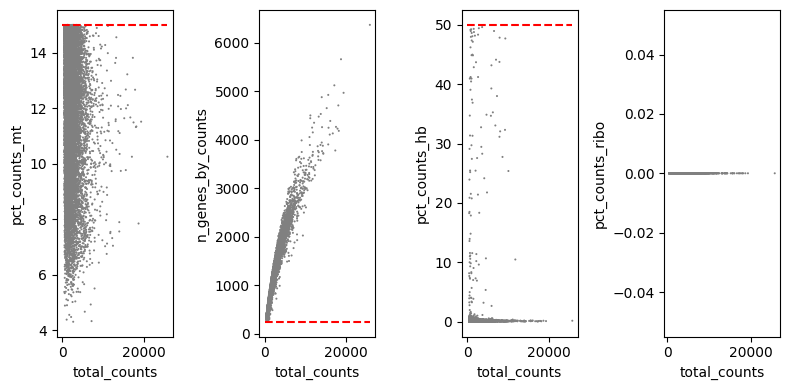

In [5]:
import matplotlib.pyplot as plt
# 阈值
mito_filter = thres['mito_perc']
n_counts_filter = thres['detected_genes']
hb_filter = thres['hb_perc']
# 设置图片布局
fig, axs = plt.subplots(ncols = 4, figsize = (8,4))
# 绘制散点图
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',ax = axs[1], show = False)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb',ax = axs[2], show=False)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo',ax = axs[3], show=False)
# 绘制阈值标志线
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[2].hlines(y = hb_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
# 紧致边界
fig.tight_layout()
plt.show()

In [6]:
n0 = adata.n_obs
# 清理低测序深度的barcode
# inplace = True:执行后覆盖原变量
sc.pp.filter_cells(adata, min_genes=200, inplace = True)
# 清理低覆盖度的barcode
sc.pp.filter_genes(adata, min_cells=3, inplace = True)
print(f'Cells retained after Lower Coverage&Depth filtering: {adata.n_obs},\
{n0-adata.n_obs} removed.')

Cells retained after Lower Coverage&Depth filtering: 13849,0 removed.


## 过滤双细胞

In [8]:
print('Begin of post doublets removal and QC plot')
sc.pp.scrublet(adata, random_state=112)
n0 = adata.n_obs
adata_scrublet = adata[adata.obs['predicted_doublet']==False, :].copy()

print(f'Cells retained after scrublet: {adata_scrublet.n_obs}, {n0-adata_scrublet.n_obs} removed.')
print(f'End of post doublets removal and QC plots.')

Begin of post doublets removal and QC plot
Cells retained after scrublet: 13726, 123 removed.
End of post doublets removal and QC plots.


## 保存

In [9]:
adata_qc = adata_scrublet
print(adata_scrublet)
adata_qc.write(f"data/{config['project_code']}_after_qc.h5ad")

AnnData object with n_obs × n_vars = 13726 × 18163
    obs: 'condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'passing_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'


# 归一化_linux
两个里面随便挑一个，通常用第一个.这一步不保存，仅作可视化

## 移位对数

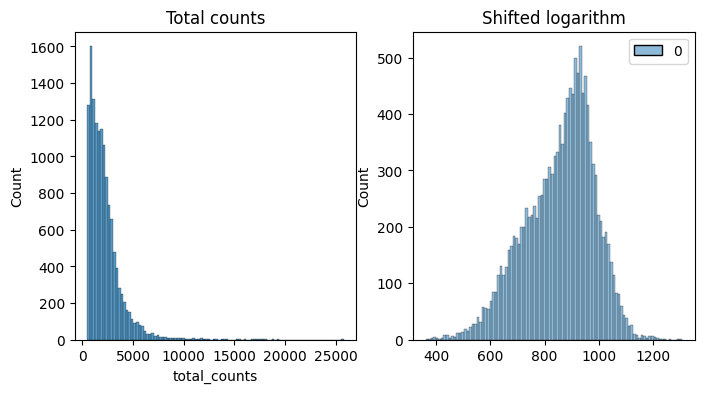

In [10]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import yaml
import os
import seaborn as sns
import matplotlib.pyplot as plt

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = ad.read_h5ad(f"data/{config['project_code']}_after_qc.h5ad")
targets = pd.read_csv("data/targets.csv")
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

## 皮尔森近似残差

computing analytic Pearson residuals on adata.X
    finished (0:00:02)


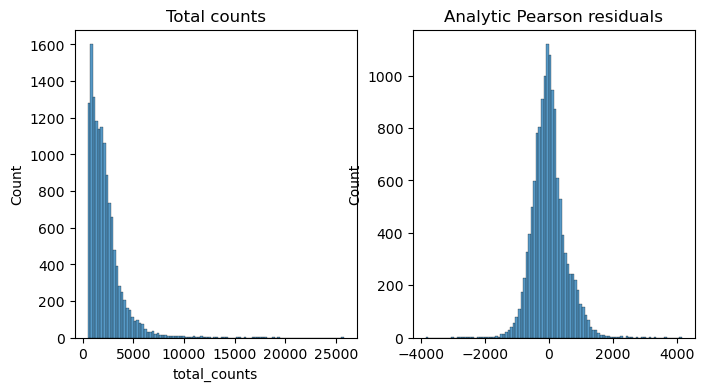

In [9]:
from scipy.sparse import csr_matrix

analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    np.nan_to_num(adata.layers["analytic_pearson_residuals"].toarray()).sum(axis=1),
    bins=100, kde=False, 
    ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

# 特征基因选择

## 数据加载与基因初筛
| 正则表达式                             | 基因来源                     | 删减原因                                               |
|----------------------------------------|------------------------------|--------------------------------------------------------|
| `^Gm`                                  | 小鼠预测基因（Gene models）  | 未经验证的自动注释基因，稳定性差，生物学意义不确定     |
| `Rik$`                                 | RIKEN 预测基因               | 功能未知，通常是日本理化研究所（RIKEN）命名的预测基因，分析中作用不明确 |
| `^CT\|^BC`                              | 克隆/文库构建编号             | 非标准基因名，无功能注释，可能为临时技术编号            |
| `Mir\|Ftx\|Tsix\|Firre\|Snhg\|Kcnq1ot1`     | 非编码 RNA（miRNA/lncRNA）   | 非编码转录本，常影响降维与聚类，部分调控基因             |
| `Eif2s3y\|Ddx3y\|Uty\|Kdm5d`              | Y 染色体基因                 | 男性特异性表达，可能引入性别偏倚                         |
| `^Rps\|^Rpl`                            | 核糖体蛋白基因               | 高表达背景噪音，主成分分析/聚类易受其主导                |
| `^mt-`                                 | 线粒体基因（小鼠）           | 线粒体表达高说明细胞可能死亡，常在 QC 时去除              |


In [1]:
%reset -f
import scanpy as sc
import pandas as pd
import yaml
import os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)


adata = sc.read(f"data/{config['project_code']}_after_qc.h5ad")
#存储原始数据以便后续还原
adata.layers['counts']=adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['log_norm']=adata.X.copy()

# 筛选前去掉有问题的基因
# 把所有基因名取出来
genes = adata.var_names

# 构建布尔掩码，保留你想保留的基因
mask = ~genes.str.match("^Gm") \
        & ~genes.str.endswith("Rik") \
        & ~genes.str.match("^CT|^BC") \
        & ~genes.str.contains("Mir|Ftx|Tsix|Firre|Snhg|Kcnq1ot1", case=False) \
        & ~genes.str.contains("Eif2s3y|Ddx3y|Uty|Kdm5d", case=False) \
        & ~genes.str.match("^Rps|^Rpl", case=False) \
        & ~genes.str.match("^mt-", case=False)

# 应用这个掩码来过滤基因
adata = adata[:, mask].copy()

'/Volumes/MacPassport/project/bioinformatics_project/GSE142445'

## 基于基因离散度

### 指定高可变基因数

In [2]:
adata_dis_num=sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",
    n_top_genes=2000,
    subset=False,
    inplace=False,
)
adata_dis_num

,means,dispersions,mean_bin,dispersions_norm,highly_variable
Xkr4,0.004632,0.388931,"(-0.00455, 0.229]",0.577279,False
Rp1,0.000547,-0.018592,"(-0.00455, 0.229]",-1.028668,False
Sox17,0.098096,0.713224,"(-0.00455, 0.229]",1.855243,True
Mrpl15,0.092660,0.237258,"(-0.00455, 0.229]",-0.020425,False
Lypla1,0.066542,0.182527,"(-0.00455, 0.229]",-0.236108,False
...,...,...,...,...,...
AC125149.3,0.000760,0.276695,"(-0.00455, 0.229]",0.134985,False
AC168977.1,0.000287,0.015989,"(-0.00455, 0.229]",-0.892395,False
PISD,0.442722,0.698723,"(0.229, 0.458]",0.736749,True
DHRSX,0.049051,0.188632,"(-0.00455, 0.229]",-0.212047,False


### 指定基因离散度与平均度阈值

In [3]:
adata_dis_cutoff=sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",
    min_disp=0.5,
    min_mean=0.0125,
    max_mean=3,
    subset=False,
    inplace=False,
)
adata_dis_cutoff['highly_variable'].value_counts()

highly_variable
False    13844
True      1435
Name: count, dtype: int64

## 基于基因归一化方差

In [5]:
adata_var_num=sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    layer='counts',
    n_top_genes=2000,
    subset=False,
    inplace=False,
)
adata_var_num['highly_variable'].value_counts()

highly_variable
False    13279
True      2000
Name: count, dtype: int64

## 基于基因皮尔森近似残差

In [6]:
adata_pearson_num=sc.experimental.pp.highly_variable_genes(
    adata, 
    flavor="pearson_residuals",
    layer='counts',
    n_top_genes=2000,
    subset=False,
    inplace=False,
)
adata.var["highly_variable"] = adata_pearson_num["highly_variable"]
adata_pearson_num['highly_variable'].value_counts()

targets = pd.read_csv("data/targets.csv")
adata

AnnData object with n_obs × n_vars = 13726 × 15279
    obs: 'condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'passing_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable'
    uns: 'scrublet', 'log1p'
    layers: 'counts', 'log_norm'

## 三种方法取得高变基因交集可视化

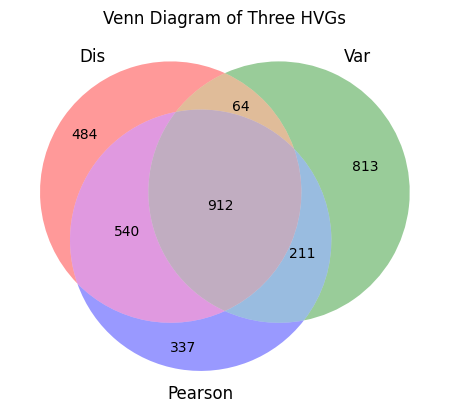

In [8]:
adata_dis_num.index=adata.var_names.copy()
adata_dis_cutoff.index=adata.var_names.copy()
adata_var_num.index=adata.var_names.copy()
adata_pearson_num.index=adata.var_names.copy()

import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# 三个列表的元素
list1 = set(adata_dis_num.loc[adata_dis_num['highly_variable']==True].index.tolist())
list2 = set(adata_var_num.loc[adata_var_num['highly_variable']==True].index.tolist())
list3 = set(adata_pearson_num.loc[adata_pearson_num['highly_variable']==True].index.tolist())

# 绘制 Venn 图
venn = venn3([list1, list2, list3], set_labels=('Dis', 'Var', 'Pearson'))

# 显示图形
plt.title("Venn Diagram of Three HVGs")
plt.show()

# 去除批次效应

## 预处理

In [9]:
%reset -f
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import yaml
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_after_qc.h5ad")
display(adata)
# 备份原始数据
adata.raw = adata.copy()

# 筛选前去掉有问题的基因
# 把所有基因名取出来
genes = adata.var_names
# 构建布尔掩码，保留你想保留的基因
mask = ~genes.str.match("^Gm") \
        & ~genes.str.endswith("Rik") \
        & ~genes.str.match("^CT|^BC") \
        & ~genes.str.contains("Mir|Ftx|Tsix|Firre|Snhg|Kcnq1ot1", case=False) \
        & ~genes.str.contains("Eif2s3y|Ddx3y|Uty|Kdm5d", case=False) \
        & ~genes.str.contains("^Hb[ab]-[^\t\n]+.*$", case=False) \
        & ~genes.str.match("^Rps|^Rpl", case=False) \
        & ~genes.str.match("^mt-", case=False)
# 应用这个掩码来过滤基因
adata = adata[:, mask].copy()

# 归一化
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# 筛选高可变基因
# batch_key:按样本筛选高变基因
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
# highly_variable_nbatches：哪一个样本的batch中出现的hvg，0代表非hvg
adata = adata[:, adata.var.highly_variable]
# 输出高变基因供查找
pd.Series(adata.var.index).to_csv("data/hvg.csv")

AnnData object with n_obs × n_vars = 13726 × 18163
    obs: 'condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'passing_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

## harmony去除批次效应

In [10]:
# harmony
sc.tl.pca(adata, n_comps=50)
# 包的作者停止维护了，如果不能安装，强制安装即可
# pip install harmonypy (--no-deps)
sce.pp.harmony_integrate(adata=adata, key='sample',
                         basis='X_pca',
                         max_iter_harmony = 20,
                         theta = None,
                         lamb = None,
                         sigma = 0.1, 
                         nclust = None,
                         tau = 0,
                         block_size = 0.05, 
                         max_iter_kmeans = 20,
                         epsilon_cluster = 1e-5,
                         epsilon_harmony = 1e-4, 
                         adjusted_basis='X_harmony')
# umap
sc.pp.neighbors(adata=adata, use_rep='X_harmony')
sc.tl.umap(adata=adata)
# tsne
sc.tl.tsne(adata=adata, use_rep='X_harmony')
display(adata)
adata.write(f"data/{config['project_code']}_harmonized.h5ad")
adata.obsm

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
2025-07-18 20:12:30,461 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-18 20:12:34,258 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-18 20:12:34,290 - harmonypy - INFO - Iteration 1 of 20
2025-07-18 20:12:36,332 - harmonypy - INFO - Iteration 2 of 20
2025-07-18 20:12:38,491 - harmonypy - INFO - Iteration 3 of 20
2025-07-18 20:12:40,647 - harmonypy - INFO - Iteration 4 of 20
2025-07-18 20:12:42,761 - harmonypy - INFO - Iteration 5 of 20
2025-07-18 20:12:44,996 - harmonypy - INFO - Iteration 6 of 20
2025-07-18 20:12:47,030 - harmonypy - INFO - Iteration 7 of 20
2025-07-18 20:12:48,904 - harmonypy - INFO - Converged after 7 iterations
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/tqdm/auto.py:21:

AnnData object with n_obs × n_vars = 13726 × 2000
    obs: 'condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'passing_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne'
    obsm: 'X_pca', 'X_harmony', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

AxisArrays with keys: X_pca, X_harmony, X_umap, X_tsne

## 可视化

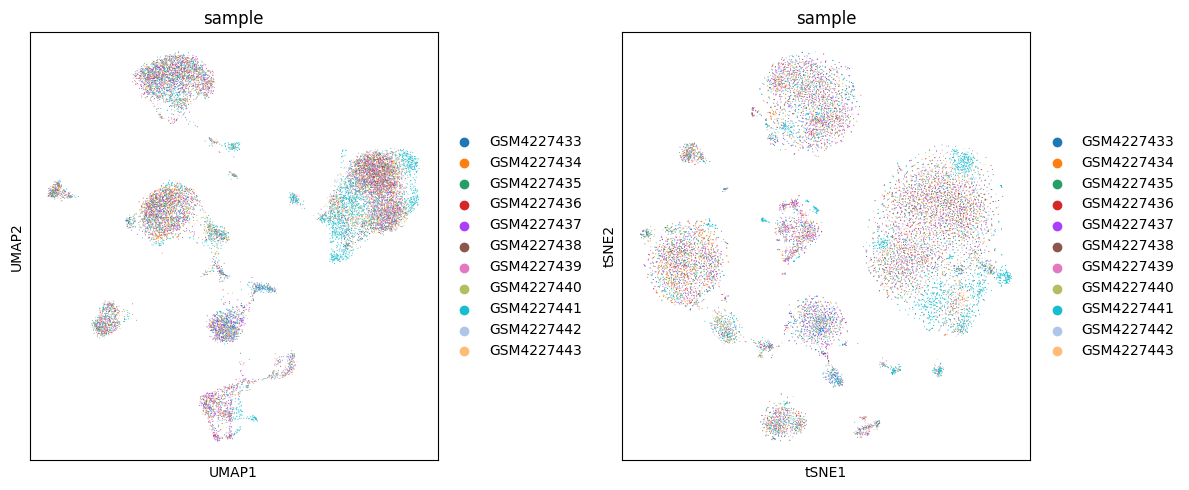

In [11]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata, color="sample", size=2, ax=ax1, show=False)
sc.pl.tsne(adata, color="sample", size=2, ax=ax2, show=False)
plt.tight_layout()
plt.show()

# 聚类

## 预处理

In [12]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_harmonized.h5ad")

'/Volumes/MacPassport/project/bioinformatics_project/GSE142445'

## 基于leiden算法的聚类

In [16]:
for res in [0.25, 0.5, 1, 1.5, 2]:
    sc.tl.leiden(adata, flavor="leidenalg", directed=False, resolution=res, key_added=f"leiden_res{res}",)

adata.write(f"data/{config['project_code']}_cluster.h5ad")

/var/folders/dt/7dzhx38d0nj0_rtw34d7trx00000gn/T/ipykernel_8395/3453449296.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, flavor="leidenalg", directed=False, resolution=res, key_added=f"leiden_res{res}",)


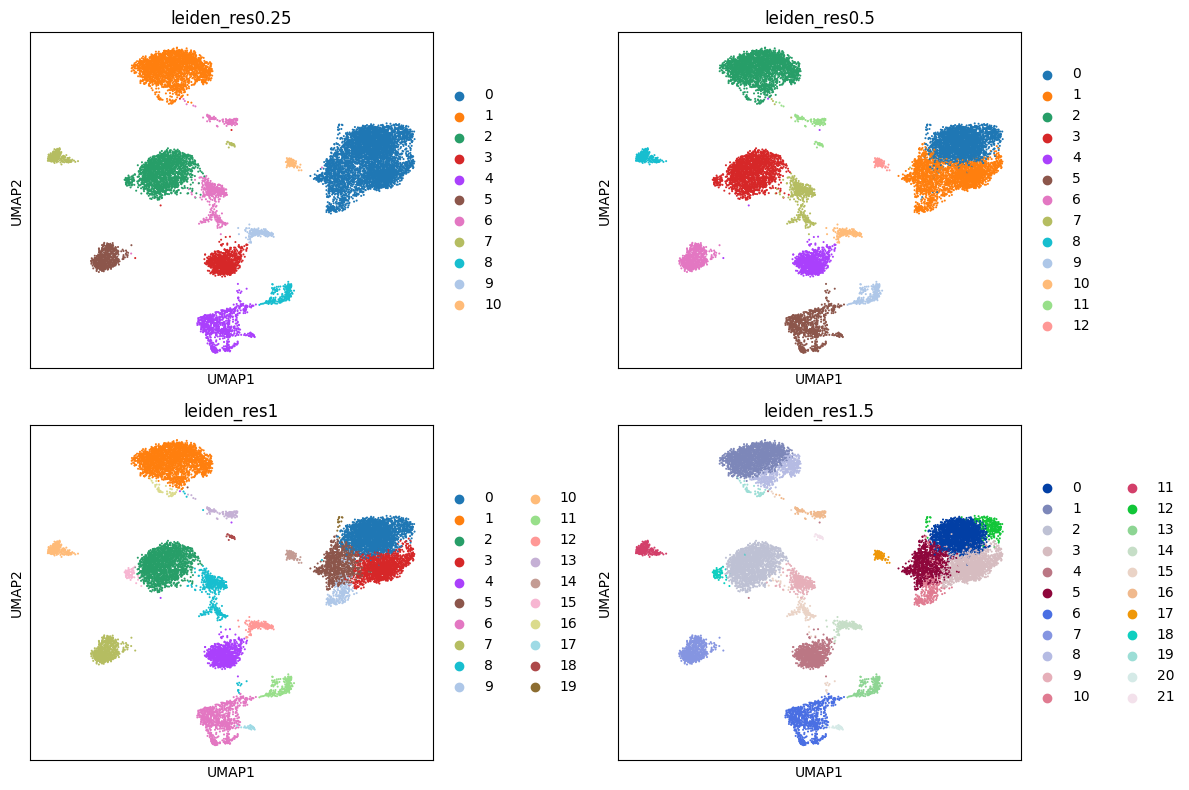

In [17]:
color_list = ["leiden_res0.25", "leiden_res0.5",  "leiden_res1",  "leiden_res1.5"]

# 指定网格布局
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))

# 将 axes 转换为一维数组以便迭代（如果行列数 > 1）
axes_flat = axes.flatten()

# 为每个 color 绘制 UMAP 图
for i, color in enumerate(color_list):
    if i < n_rows * n_cols:  # 确保不超出子图数量
        ax = axes_flat[i]
        sc.pl.umap(adata, color=color, ax=ax, show=False, title=color)
    else:
        break  # 如果 color_list 比子图多，停止绘制

# 隐藏多余的子图（如果 color_list 不足以填满网格）
for i in range(len(color_list), n_rows * n_cols):
    axes_flat[i].axis("off")

# 调整布局以避免重叠
plt.tight_layout()
plt.savefig("figures/all_leiden_result.pdf")

# 细胞类型注释

## 逐细胞簇差异分析

In [18]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_cluster.h5ad")

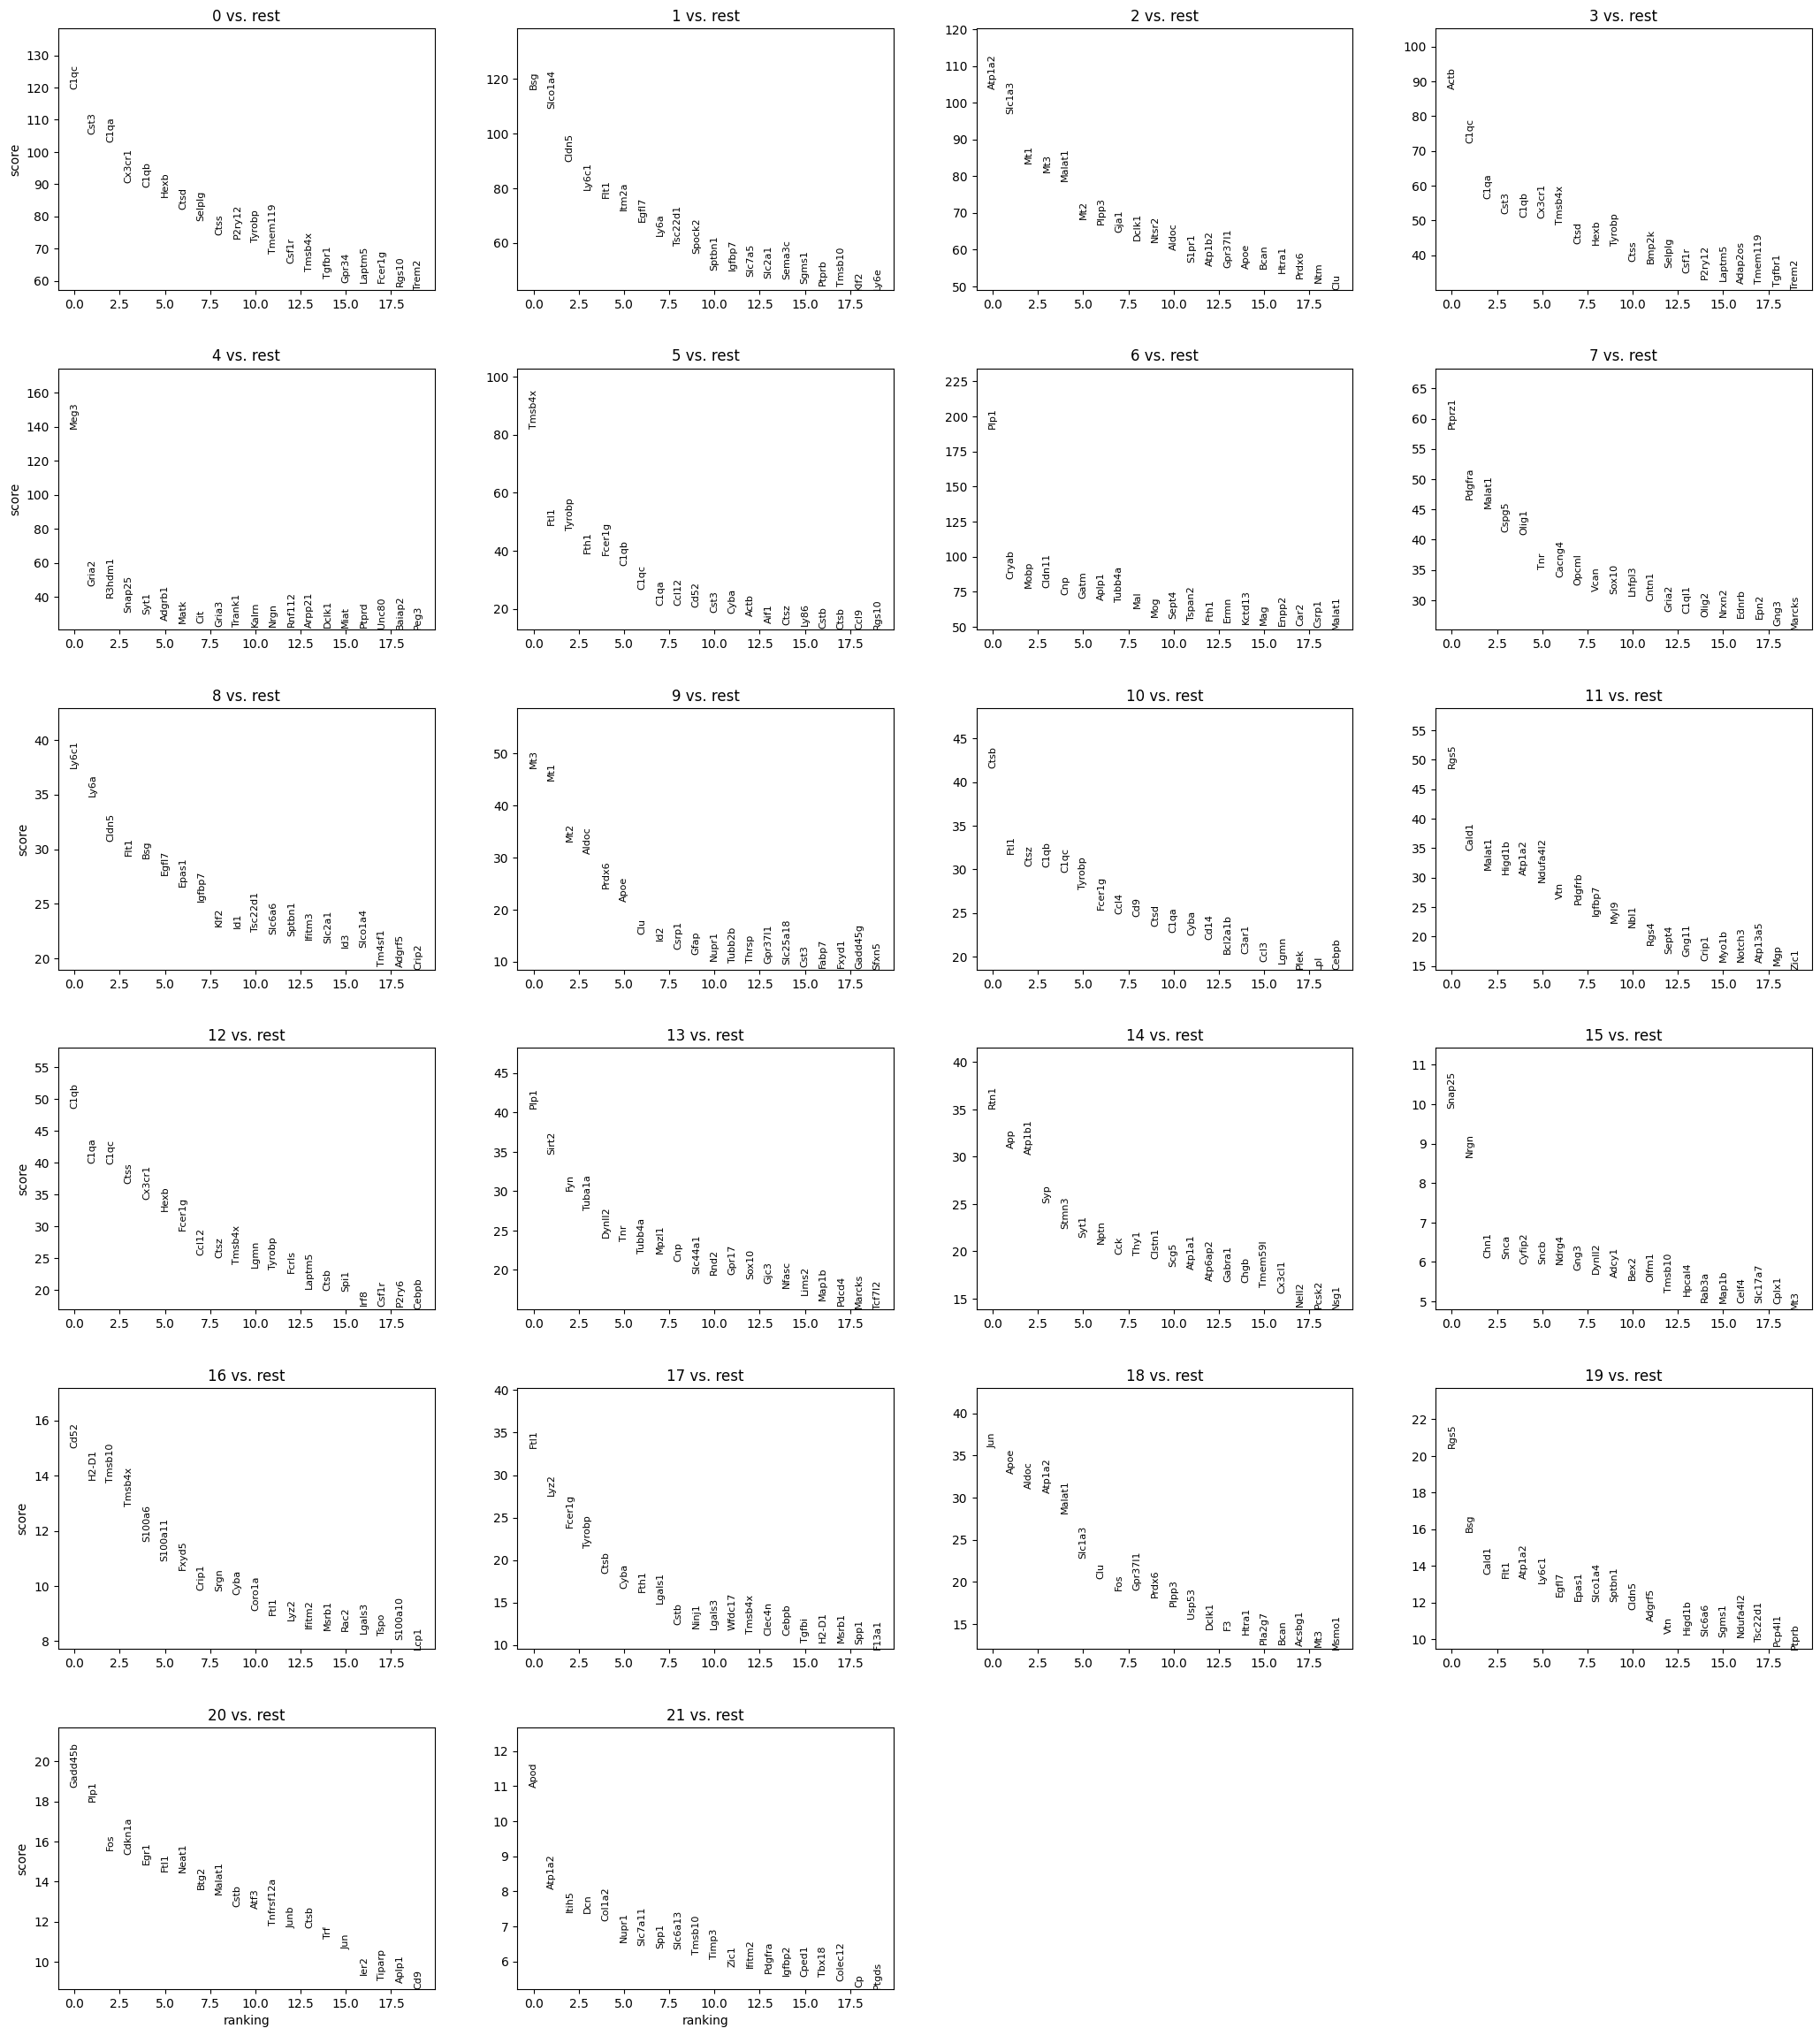

In [8]:
import warnings
warnings.filterwarnings('ignore')
# 找不到分群的时候查一下
adata_rank = sc.tl.rank_genes_groups(adata, "leiden_res1.5", method="t-test", use_raw=False, copy=True, pts=True)
# 结果存储在adata_rank.uns['rank_genes_groups']['names']
# 可视化分群结果
sc.pl.rank_genes_groups(adata_rank, n_genes=20, sharey=False)

if not os.path.exists("result/deg_by_leiden_cluster"):
    os.makedirs("result/deg_by_leiden_cluster")

for celltype in adata_rank.uns['rank_genes_groups']["names"].dtype.names:
    res = pd.DataFrame({'names': adata_rank.uns['rank_genes_groups']["names"][celltype], 
                        'scores': adata_rank.uns['rank_genes_groups']["scores"][celltype],
                        'pvals': adata_rank.uns['rank_genes_groups']["pvals"][celltype],
                        'pvals_adj': adata_rank.uns['rank_genes_groups']["pvals_adj"][celltype],
                        'log2foldchanges': adata_rank.uns['rank_genes_groups']["logfoldchanges"][celltype]})
    res = res.sort_values(by=["log2foldchanges","pvals"], ascending=[False, True])
    mask = (res['log2foldchanges'].abs() > 1) & (res['pvals'] < 0.05)
    res.loc[mask,:].to_csv(f"result/deg_by_leiden_cluster/deg_of_{celltype}.tsv", index=None, sep="\t")

# 重置warning
warnings.resetwarnings()
# 保存差异分析结果
adata_rank.write(f"data/{config['project_code']}_annotated.h5ad")

## 基于经验marker的SCINA算法半自动标注结果

|分组|细胞类型|基因|
|----|-------|----|
|血液|Erythroid progenitor cell|['Adgre1','Csf1r','Epor','Gata1','Gypa','Klf1','Hbb-a1']|
|血液|Immune cell|["Ccr7","Cd11b","Cd3","Cd3d","Cd3e","Cd3g","Cd4","Ptprc","Cd74","Cd79a","Cd8","Cd83"]|
|血液|T cell|["Cd3d", "Cd3e", "Cd3g"]|
|血液|B cell|["Cd79a","Ms4a1","Cd19"]|
|血液|Dendritic cell|["Clec9a", "Flt3", "Zbtb46"]|
|血液|Monocyte|['Ly6c2','Ccr2','Cd68']|
|血液|Macrophage|["Iba1", "Mrc1", "Cd68", "F13a1","Itgam"]|
|血液|Neutrophil|["Lcn2", "Ly6g", "S100a8","Mmp8","Mmp9"]|
|血液|Mast cell|["Kit","Tpsb2","Tpsab1"]|
|血脑屏障及其附属结构|Vascular cells|["Myl9", "Mgp46"]|
|血脑屏障及其附属结构|Vascular endothelial cell|["Cldn5","Pecam1","Cdh5","Slc38a5"]|
|血脑屏障及其附属结构|Vascular smooth muscle cell|["Myh11","Acta2","Tagln","Rgs5"]|
|血脑屏障及其附属结构|Endothelial cell|["Esam"]|
|血脑屏障及其附属结构|Pericyte|["Rgs5","Abcc9","Kcnj8","Pdgfrb"]|
|血脑屏障及其附属结构|Fibroblast|["Col1a1","Dcn","Pdgfra","Col3a1"]|
|血脑屏障及其附属结构|Schwann cell|["Mbp","Ttr"]|
|血脑屏障及其附属结构|Choroid cells|["Lcn2"]|
|血脑屏障及其附属结构|Choroid plexus cell|["Folr1"]|
|血脑屏障及其附属结构|Ependymal cell|['Ccdc153','Foxj1','Tmem212','Dnah11','Ccdc153','Foxj1','Tmem212','Dnah11']|
|脑实质组织|Oligodendrocyte|["Mbp", "Mog","Olig2","Olig1","Plp1","Mag","Cldn11"]|
|脑实质组织|Oligodendrocyte progenitor cell|["Pdgfra", "Ascl1", "Dcn", "Ednrb","Ng2"]|
|脑实质组织|Oligodendrocyte precursor cell|["Pdgfra", "Olig1","Cacng4","Olig2","Sox10"]|
|脑实质组织|Microglial cell|["Tmem119","Cx3cr1","P2ry12","Iba1","Csf1r","C1qa","Cd11b","Itgam","Fcrls","Cd68","Aif1","Sall1","Hexb","F11r"]|
|脑实质组织|Astrocyte|["Gfap", "Aqp4", "Gja1"]|
|脑实质组织|Neuron|["Rbfox3","Snap25","Map2","Tubb3","Stmn2","Dcx"]|

In [20]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import json
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_annotated.h5ad")

# 加载小字典
with open("data/small_marker_dict.json", "r", encoding="utf-8") as f:
    small_marker_dict = json.load(f)

# 对比微型细胞类型标注字典，留下存在于测序数据中的marker基因
# 这里一定要在raw矩阵中搜索，否则可能会因为质控的hvg筛选而搜不到基因
smarker_genes_in_data = dict()
for celltype, markers in small_marker_dict.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.raw.var.index:
            markers_found.append(marker)
    smarker_genes_in_data[celltype] = markers_found

# 除去不包含任何marker基因值的细胞类型键
del_markers = list()
for celltype, markers in smarker_genes_in_data.items():
    if markers==[]:
        del_markers.append(celltype)
for celltype in del_markers:
    del smarker_genes_in_data[celltype]

smarker_genes_in_data.keys()

dict_keys(['Erythroid progenitor cell', 'Immune cell', 'T cell', 'B cell', 'Dendritic cell', 'Macrophage', 'Neutrophil', 'Vascular cells', 'Vascular endothelial cell', 'Vascular smooth muscle cell', 'Endothelial cell', 'Pericyte', 'Fibroblast', 'Schwann cell', 'Choroid plexus cell', 'Ependymal cell', 'Oligodendrocyte', 'Oligodendrocyte progenitor cell', 'Oligodendrocyte precursor cell', 'Microglial cell', 'Astrocyte', 'Neuron'])

In [21]:
# scinapy 半监督分类
import SCINApy as scina
scina.SCINA(adata=adata, signatures=small_marker_dict, allow_unknown=False, inplace=True)
adata.obs = adata.obs.rename(columns={'scina_labels': 'scina_local_labels'})
adata.write(f"data/{config['project_code']}_annotated.h5ad")

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term

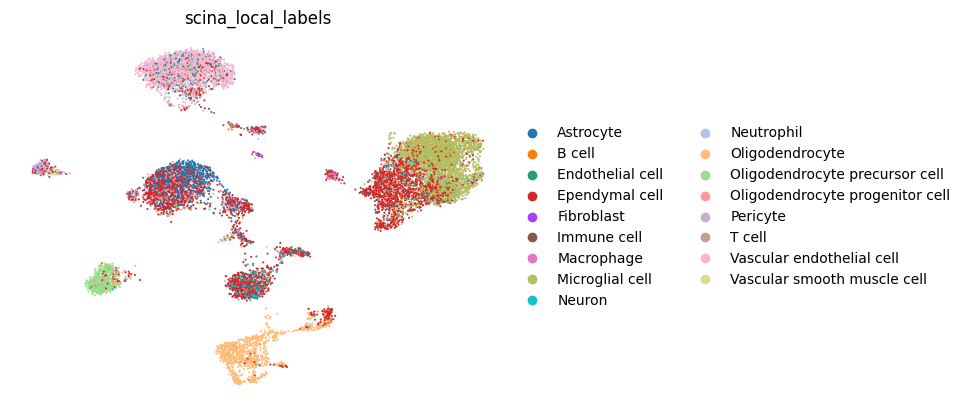

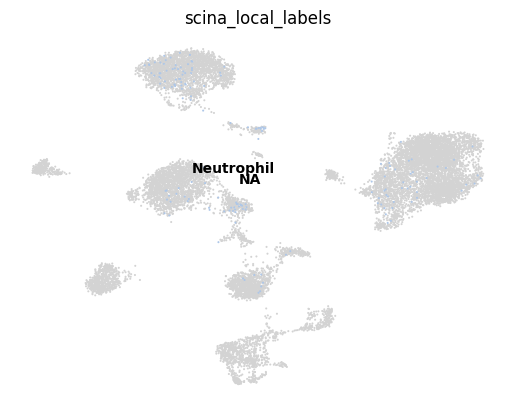

In [24]:
sc.pl.umap(adata, frameon=False, color='scina_local_labels')
sc.pl.umap(adata, frameon=False, groups='Neutrophil', legend_loc='on data', color='scina_local_labels')

## 手动注释（基于聚类）

1. 优先认可自动注释结果，要求平均可能性超过50%
2. 其次选择手动注释结果，要求高表达量占比超过50%

In [29]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_annotated.h5ad")
cluster_key_chosen = "leiden_res1.5"

The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
saving figure to file figures/umap/annotation/Oligodendrocyte progenitor cell.pdf


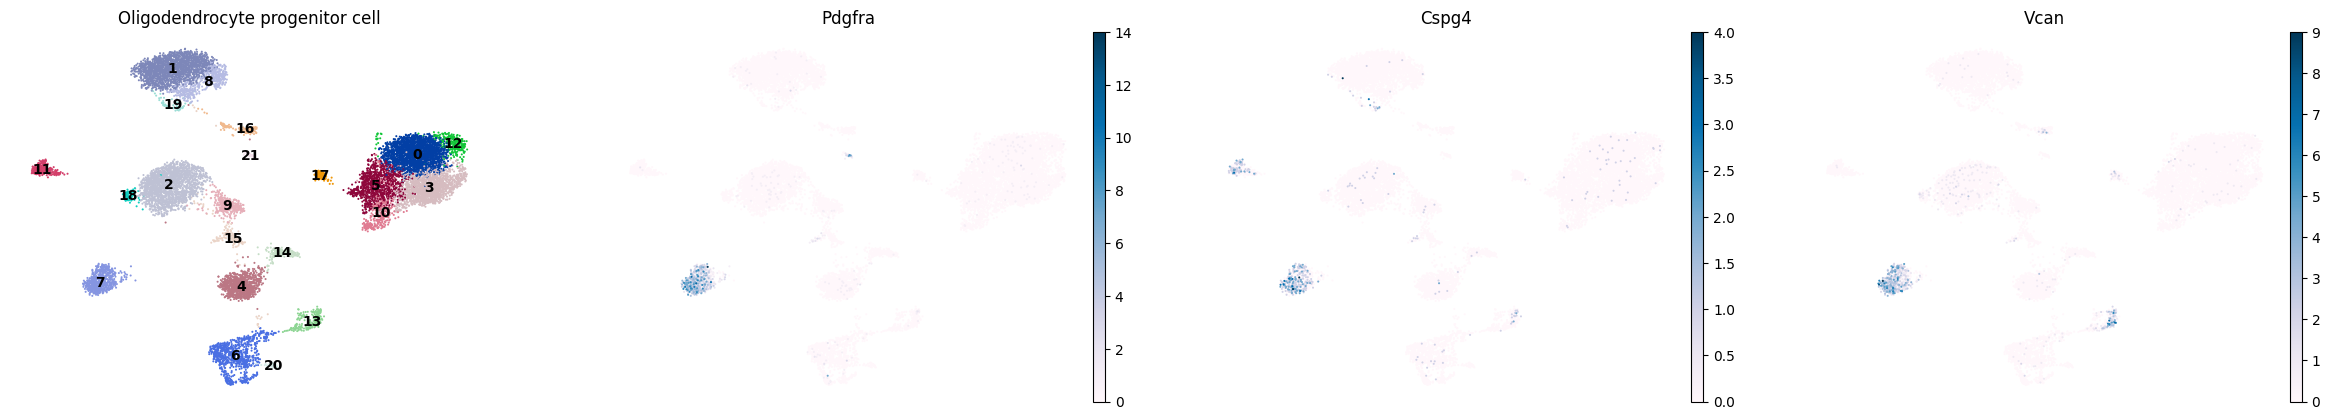

The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than the number of panels. Using 'color' value instead for some plots.
The title list is shorter than

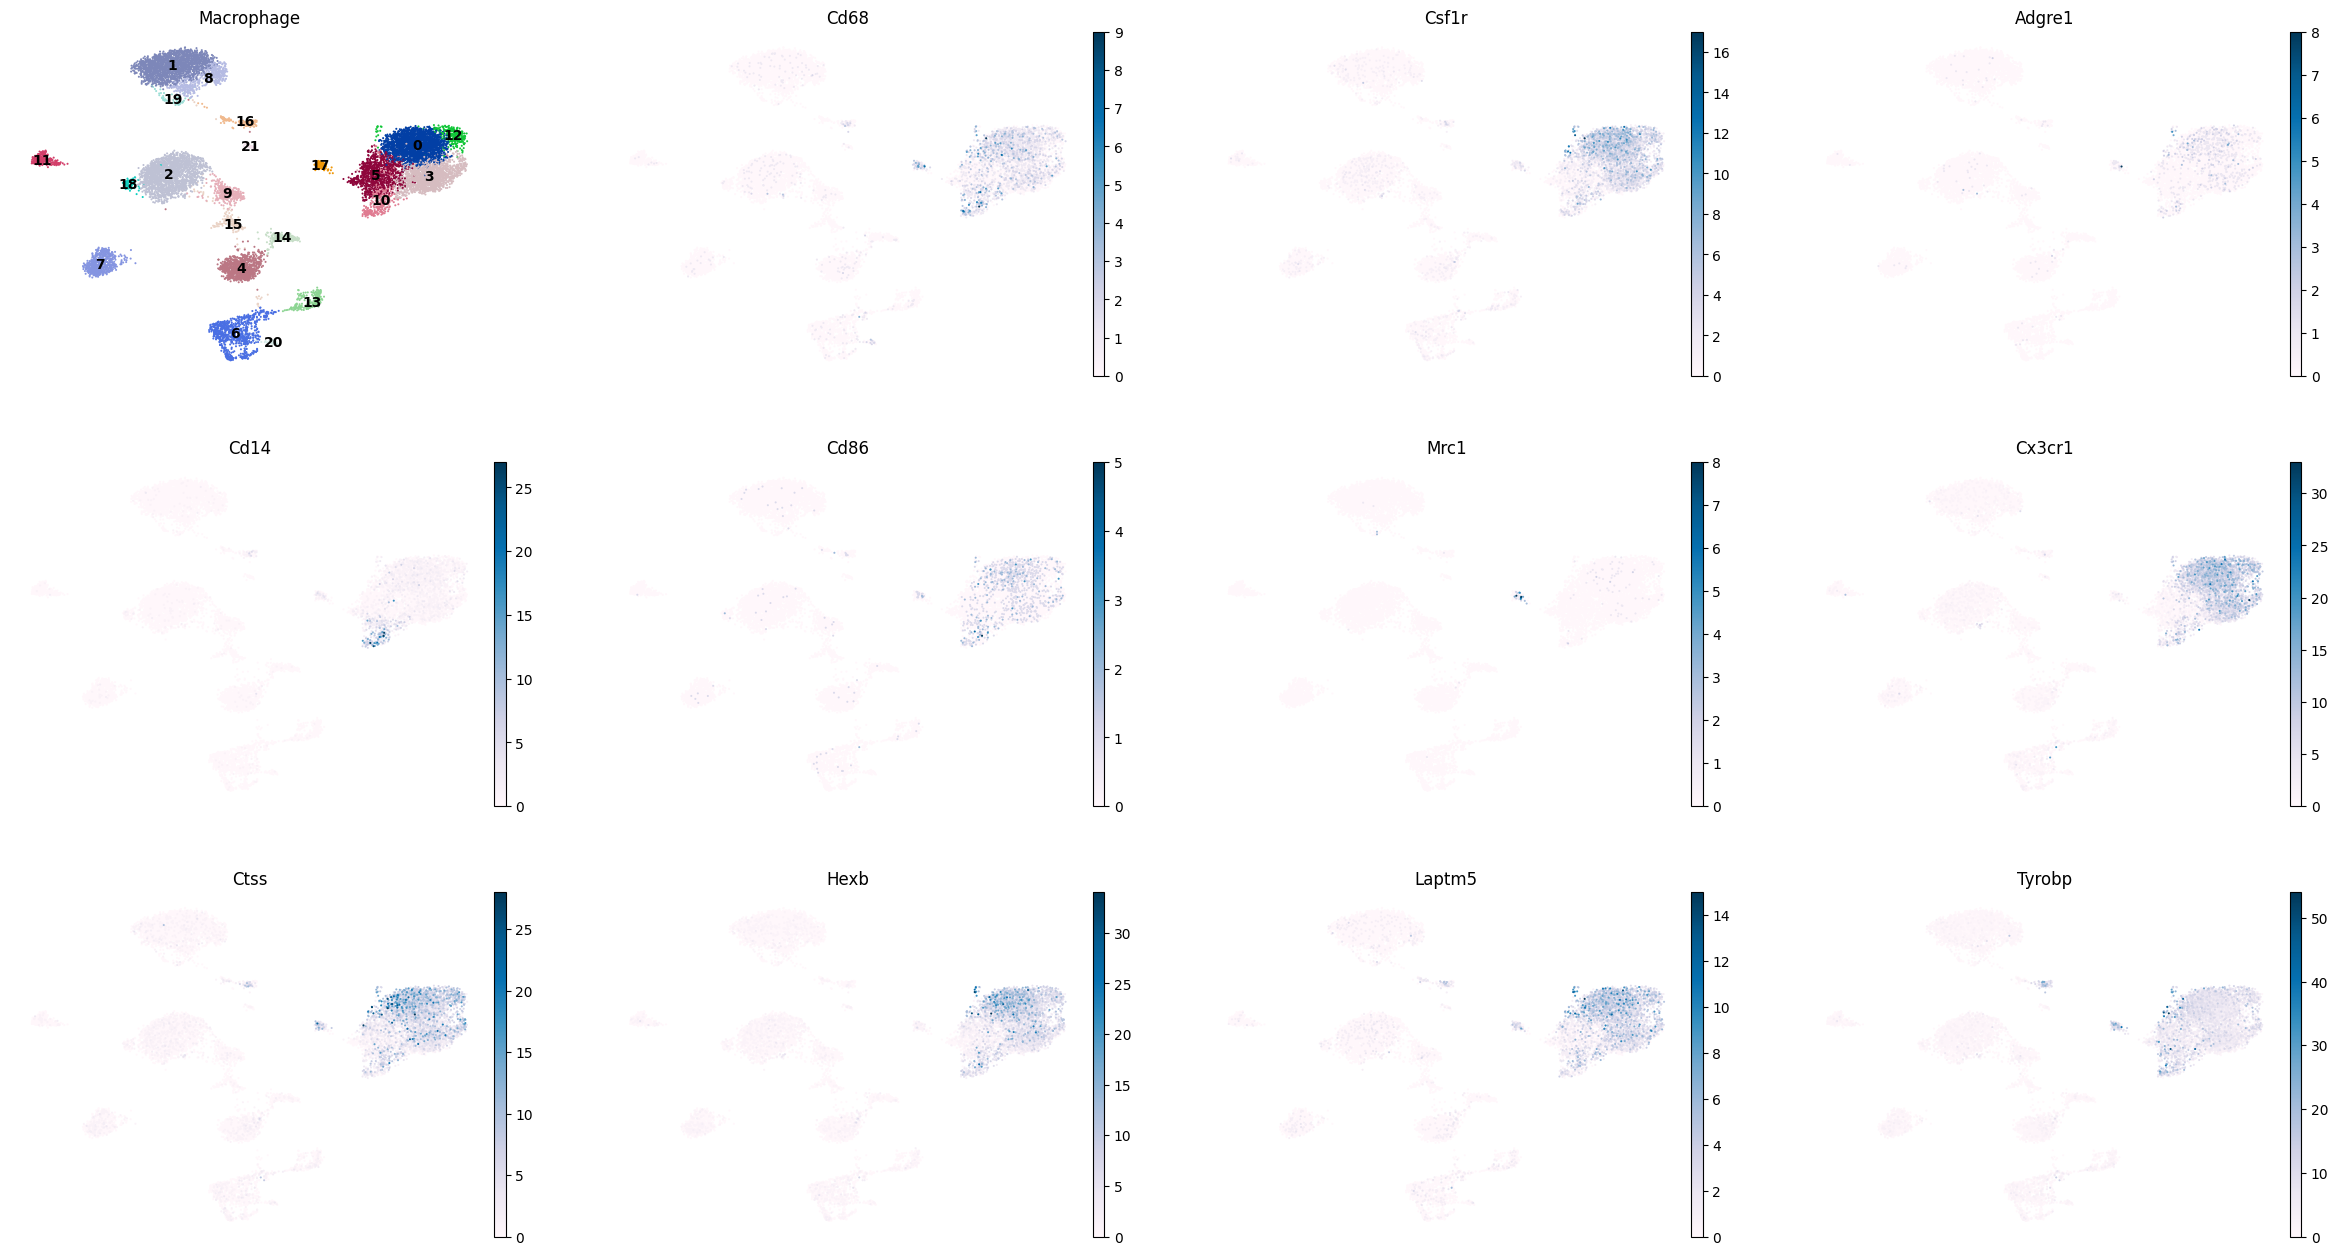

In [ ]:
os.makedirs("figures/umap/annotation/", exist_ok=True)
# # 神经元
# sc.pl.umap(adata, frameon=False, title="Neuron", legend_loc='on data', color=[cluster_key_chosen, "Meg3","Rbfox3","Snap25","Map2","Tubb3","Stmn2","Dcx"], cmap='PuBu', save="/annotation/Neuron.pdf")
# # 谷氨酸能神经元
# # Slc17a6转录成VGLUT2蛋白(谷氨酸转运体2，Vesicular Glutamate Transporter 2), 主要在皮层下区域（如丘脑、脑干）和部分皮层神经元中高表达
# # Slc17a7是VGLUT1蛋白，主要在大脑皮层（如新皮层）和海马的兴奋性神经元中高表达
# # Satb2 是一种转录因子，结合富含AT的DNA序列，特别是在上层皮层神经元起关键作用
# sc.pl.umap(adata, frameon=False, title="Glutamatergic neurons", legend_loc='on data', color=[cluster_key_chosen, "Slc17a6", 'Slc17a7', 'Satb2'], cmap='PuBu')
# # GABA能神经元
# sc.pl.umap(adata, frameon=False, title="GABAergic neurons", legend_loc='on data', color=[cluster_key_chosen, 'Gad1', 'Gad2'], cmap='PuBu')

# # 星形胶质细胞
# sc.pl.umap(adata, frameon=False, title="Astrocyte", legend_loc='on data', color=[cluster_key_chosen, 'Aqp4', 'Atp1b2', 'Gfap', 'S100b', 'Aldh1l1', 'Aldoc', 'Slc1a2', 'Slc1a3'], cmap='PuBu', 
#            save="/annotation/Astrocyte.pdf")
# # 成纤维细胞
# sc.pl.umap(adata, frameon=False, title="Fibroblast", legend_loc='on data', color=[cluster_key_chosen, 'Col1a1', 'Col1a2', 'Fn1'], cmap='PuBu', 
#            save="/annotation/Fibroblast.pdf")
# # 少突胶质细胞
# sc.pl.umap(adata, frameon=False, title="Oligodendrocyte", legend_loc='on data', color=[cluster_key_chosen, 'Mbp', 'Plp1', 'Cldn11', 'Mobp'], cmap='PuBu', 
#            save="/annotation/Oligodendrocyte.pdf")
# 少突胶质祖细胞 Oigodendrocyte progenitor cell
sc.pl.umap(adata, frameon=False, title="Oligodendrocyte progenitor cell", legend_loc='on data', color=[cluster_key_chosen, 'Pdgfra', 'Cspg4', 'Vcan'], cmap='PuBu', 
           save="/annotation/Oligodendrocyte progenitor cell.pdf")

# # 小胶质细胞
# sc.pl.umap(adata, frameon=False, title="Microglia", legend_loc='on data', color=[cluster_key_chosen, 'Tmem119', 'Cx3cr1', 'Aif1'], cmap='PuBu', 
#            save="/annotation/Microglia.pdf")
# 巨噬细胞
# M2巨噬细胞可能高表达 Mrc1
sc.pl.umap(adata, frameon=False, title="Macrophage", legend_loc='on data', 
           color=[cluster_key_chosen, 'Cd68', 'Csf1r', 'Adgre1', 'Cd14', 'Cd86', 'Mrc1', 'Cx3cr1', 'Ctss', 'Hexb', 'Laptm5', 'Tyrobp'], cmap='PuBu', 
           save="/annotation/Macrophage.pdf")

# # 血管细胞 Flt1就是VEGFR1
# sc.pl.umap(adata, frameon=False, title="vascular cells", legend_loc='on data', color=[cluster_key_chosen, 'Flt1', 'Cldn5'], cmap='PuBu', 
#            save="/annotation/Vascular cells.pdf")
# # 血管内皮细胞
# sc.pl.umap(adata, frameon=False, title="Vascular endothelial cell", legend_loc='on data', color=[cluster_key_chosen, 'Flt1',"Cldn5","Pecam1","Cdh5","Slc38a5"], cmap='PuBu', 
#            save="/annotation/Vascular endothelial cell.pdf")
# # 壁细胞 mural cell
# sc.pl.umap(adata, frameon=False, title="mural cell", legend_loc='on data', color=[cluster_key_chosen, 'Pdgfrb', 'Cspg4'], cmap='PuBu', 
#            save="/annotation/mural cell.pdf")
# # 周细胞 Pericyte
# sc.pl.umap(adata, frameon=False, title="Pericyte", legend_loc='on data', color=[cluster_key_chosen, "Rgs5","Abcc9","Kcnj8","Pdgfrb"], cmap='PuBu', 
#            save="/annotation/Pericyte.pdf")
# # 室管膜细胞 Ependymal cells
# sc.pl.umap(adata, frameon=False, title="Ependymal cells", legend_loc='on data', color=[cluster_key_chosen, 'Ccdc153','Foxj1'], cmap='PuBu', 
#            save="/annotation/Ependymal cells.pdf")


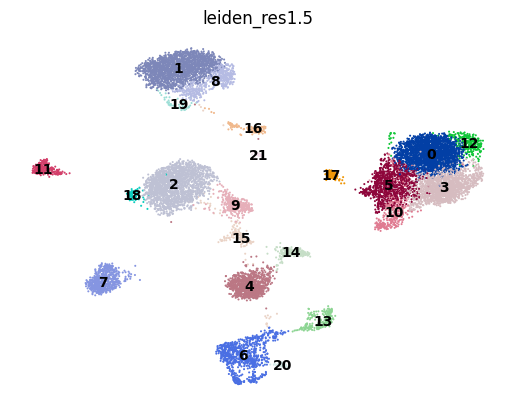

saving figure to file figures/umap_final_annotation_on_data.pdf


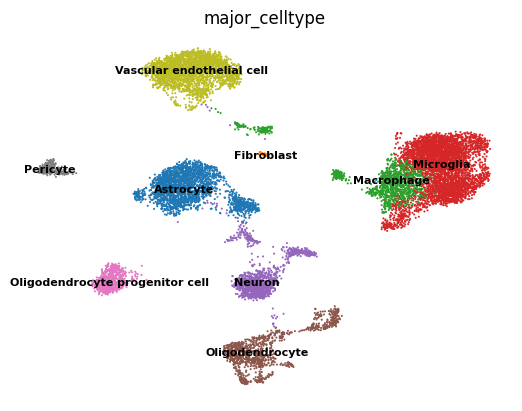

Length of palette colors is smaller than the number of categories (palette length: 3, categories length: 11. Some categories will have the same color.
saving figure to file figures/umap_final_annotation_by_sample.pdf


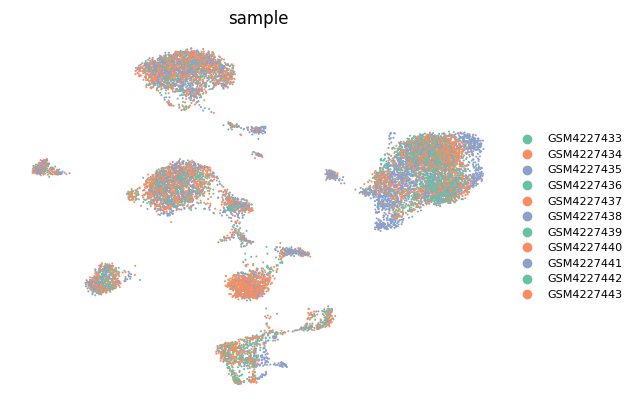

In [30]:
# ('\d+':)'[\w\s]+',\s#.* -> $1'', # 
cluster2annotation = {
    '0':'Microglia', # Microglia
    '1':'Vascular endothelial cell', # Vascular endothelial cell
    '2':'Astrocyte', # Astrocyte
    '3':'Microglia', # Microglia
    '4':'Neuron', # Neuron
    '5':'Macrophage', # Macrophage
    '6':'Oligodendrocyte', # Astrocyte/Oligodendrocyte
    '7':'Oligodendrocyte progenitor cell', # Neuron/Oligodendrocyte progenitor cell
    '8':'Vascular endothelial cell', # Vascular endothelial cell
    '9':'Astrocyte', # Astrocyte
    '10':'Microglia', # Microglia
    '11':'Pericyte', # Pericyte
    '12':'Microglia', # Microglia
    '13':'Oligodendrocyte', # Astrocyte/Oligodendrocyte
    '14':'Neuron', # Neuron
    '15':'Neuron', # Neuron
    '16':'Macrophage', # Macrophage
    '17':'Macrophage', # Macrophage
    '18':'Astrocyte', # Astrocyte
    '19':'Vascular endothelial cell', # Vascular endothelial cell
    '20':'Oligodendrocyte', # Astrocyte/Oligodendrocyte
    '21':'Fibroblast', # Fibroblast
}
adata.obs['major_celltype'] = adata.obs[cluster_key_chosen].map(cluster2annotation).astype('category')

sc.pl.umap(adata, legend_loc="on data", frameon=False, color=cluster_key_chosen)
sc.pl.umap(adata, frameon=False, color='major_celltype', legend_loc="on data", legend_fontsize=8, save="_final_annotation_on_data.pdf")
sc.pl.umap(adata, frameon=False, color='sample', legend_fontsize=8,
    palette=['#66c2a5','#fc8d62','#8da0cb'], 
    save="_final_annotation_by_sample.pdf")

# 去掉无用的obs列
# 去除'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'passing_hb'
# 去除leiden列
useful_obs_column = ['condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 
                     'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 
                     'log1p_total_counts_hb', 'pct_counts_hb',  'n_genes', 'doublet_score', 'predicted_doublet', 
                     cluster_key_chosen, 'scina_local_labels', 'major_celltype']
adata.obs = adata.obs.loc[:, useful_obs_column]
adata.write(f"data/{config['project_code']}_annotated.h5ad")

## 细胞类型占比

In [ ]:
%reset -f
# import sys
# sys.path.append(r"D:\Python\omictools")
# import omictools as otl
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import json
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_annotated.h5ad")

# 读取分组信息
targets = pd.read_csv("data/targets.csv")
display(adata)
# 百分比
cross_table = pd.crosstab(adata.obs['sample'], adata.obs['major_celltype'])
cross_table.loc["all", :] = cross_table.sum(axis=0)
percent_table = cross_table.div(cross_table.sum(axis=1), axis=0) * 100
percent_table

AnnData object with n_obs × n_vars = 13726 × 2000
    obs: 'condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden_res1.5', 'scina_local_labels', 'major_celltype'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5', 'leiden_res1.5_colors', 'leiden_res2', 'log1p', 'major_celltype_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'scina_local

major_celltype,Astrocyte,Fibroblast,Macrophage,Microglia,Neuron,Oligodendrocyte,Oligodendrocyte progenitor cell,Pericyte,Vascular endothelial cell
sample,,,,,,,,,
GSM4227433,14.169788,0.312110,2.684145,29.338327,24.219725,7.053683,4.431960,1.498127,16.292135
GSM4227434,31.737346,0.205198,2.530780,29.480164,1.573187,6.224350,4.172367,3.761970,20.314637
GSM4227435,21.667966,0.233827,1.792673,37.646142,2.494154,8.417771,6.469213,1.792673,19.485581
GSM4227436,17.806268,0.142450,4.700855,30.056980,6.980057,11.253561,6.695157,1.709402,20.655271
GSM4227437,16.862515,0.235018,1.821387,21.562867,17.861340,11.633373,3.525264,1.997650,24.500588
GSM4227438,14.064915,0.309119,1.236476,55.023184,0.154560,4.018547,1.081917,3.863988,20.247295
GSM4227439,12.519320,0.154560,2.163833,47.217929,1.545595,12.905719,6.877898,1.622875,14.992272
GSM4227440,21.413502,0.527426,3.691983,31.012658,15.084388,6.012658,5.801688,2.004219,14.451477
GSM4227441,12.504824,0.270166,27.286762,27.865689,7.217291,5.519105,3.319182,1.698186,14.318796


## 累积百分比柱状图

/var/folders/dt/7dzhx38d0nj0_rtw34d7trx00000gn/T/ipykernel_2660/2920838337.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_categories).colors
/var/folders/dt/7dzhx38d0nj0_rtw34d7trx00000gn/T/ipykernel_2660/2920838337.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


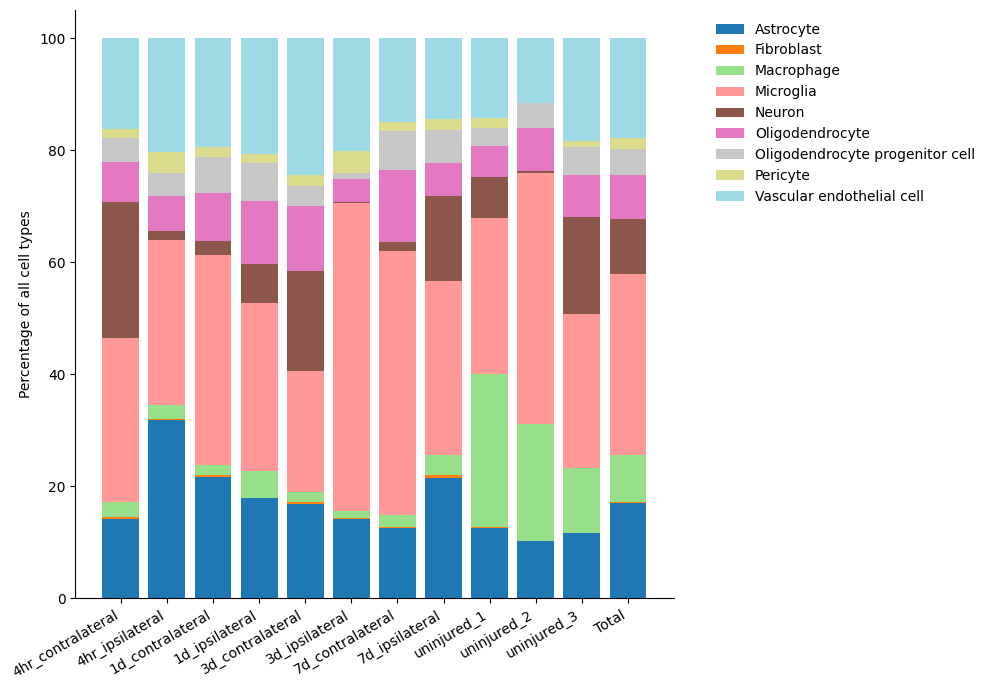

In [33]:
# plt.rcParams.update({
#     "text.usetex": True, #使用latex
#     "font.family": "serif",  # 或 "cmr" 等 LaTeX 支持的字体
#     "font.serif": ["Times New Roman"], #设置具体的字体，可以解决一些字体缺失的问题
# })

# 创建图表
plt.figure(figsize=(10,7))

# 设置背景为白色
plt.gcf().set_facecolor('white')  # 设置 figure 的背景色
plt.gca().set_facecolor('white')  # 设置 axes 的背景色

# 隐藏边框
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# 获取样本和类别
samples = percent_table.index
categories = percent_table.columns

# 初始化 bottom 数组
bottom = np.zeros(len(samples))

# 设置颜色列表
num_categories = len(categories)
colors = plt.cm.get_cmap('tab20', num_categories).colors

# 循环绘制堆叠柱状图
for i, category in enumerate(categories):
    plt.bar(samples, percent_table[category],
        # width=0.2, # 柱子的宽度
        bottom=bottom, # 柱子底部在 y 轴上的位置
        label=category, linewidth=0, color=colors[i]) # linewidth=0 去除分割线
    bottom += percent_table[category].values


# 修改 x 轴刻度标签
new_labels = list(targets['condition']) + ['Total']  # 新的标签列表
ax.set_xticklabels(new_labels)
plt.xticks(range(len(samples)), new_labels, rotation=30, ha='right')

# 添加标签、标题和图例
# plt.xlabel('Sample')
plt.ylabel('Percentage of all cell types') # 修改 y 轴标签
# plt.title('Stacked Bar Chart (Percentage)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False) # 图例放到图表外, 去掉背景和灰色外框

# 去除y轴刻度线和数字
# plt.gca().tick_params(axis='y', left=False, labelleft=False)

# 显示图表
plt.tight_layout()
plt.savefig("figures/all_celltype_percentage.pdf")

In [ ]:
summary_table = cross_table
summary_table.loc[:, "sum"]=cross_table.sum(axis=1).astype(int)

sample
GSM4227433     1602
GSM4227434     1462
GSM4227435     1283
GSM4227436      702
GSM4227437     1702
GSM4227438      647
GSM4227439     1294
GSM4227440      948
GSM4227441     2591
GSM4227442      430
GSM4227443     1065
all           13726
dtype: int64